## LSTM 预测包络线测试hithub用
将往年实际值的包络线和预测值作为训练数据，训练一个输入为预测值和一段实际值，输出为实际值包络线的LSTM模型。

首先回答一个问题：为什么不直接进行实际值的预测，再给出包络线？

想要回答这个问题，先考虑这个问题的背景。原本，我们需要的是一个带有置信度误差带，得到这个误差带可以从概率的角度计算出最坏的情况下储能决策的价值，从而做出储能决策；现在，我们将带有置信度的误差带转化为给出实际值包络线问题，对于储能的决策动作而言，这是等价的。

当一个曲线确定，显然它的包络线也就确定，没有概率可言。但是，当时间过去两年，甚至十年，将会逐步地得到一条具有概率的包络线。
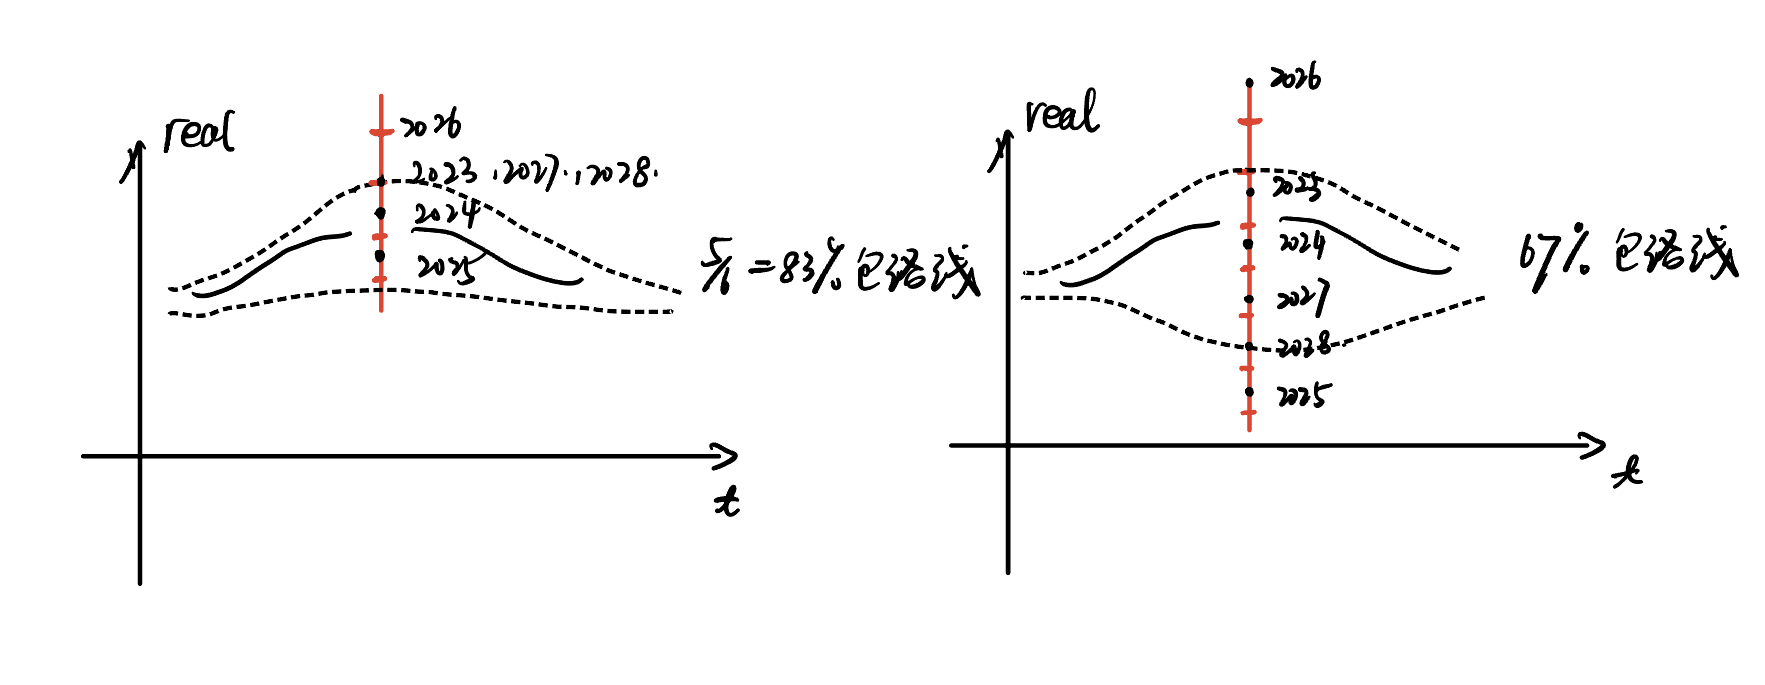
正如左图所示，当6年中有五年的数据分布在红色区间中时，可以认为画出的包络线是83%置信度的包络线。考虑到实际情况中可能实际值的分布比较分散（譬如均匀分布-右图），也可以得到有一定置信度的包络线。

在实际的模型中，我们当然不希望等待几十年来优化模型。所以当我们判断有处于相似的环境的风电场实际值时，可以一并纳入考虑。从而丰富数据集。

同时，为了完善训练集的实际值的包络线数据，也可以将往年数值天气的实际数据对实际值做一映射，增加数据量。譬如，往年的风速在这一时刻符合某一种分布，那么就认为实际出力也是符合这一分布的。下图是一个例子：

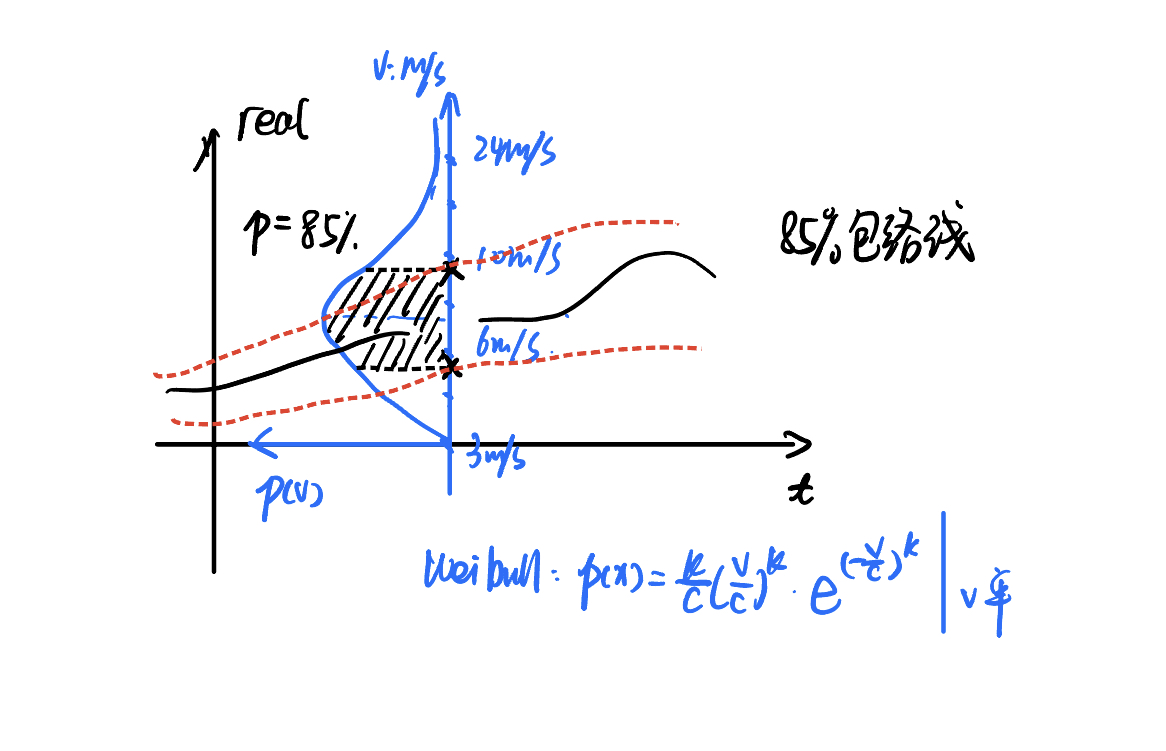

上图展示了将风速映射为概率密度，并将风速映射到实际功率大小的一种思路。蓝色曲线表示风速在这一时刻满足参数空间为（c，k）的 Weibull 分布。红色曲线是风速映射到功率后的一个实际功率包络线。风速在映射之前可以算出其分布函数的值，在示例中，是85%。也就是说，我们画出的实际值的包络线是85%置信度的包络线。

按照此方法，就无需等待多年来优化实际模型了，使得这个模型的训练集数据个数更多，也更具有更实际的可行性。

In [73]:
## 库、数据导入和变量声明
import pandas as pd
import numpy as np
import os # 用于储存图片
import re # 筛选时更为严格的日期数据
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde # 用于从直方图拟合概率密度函数
from scipy.integrate import quad # 用于从密度函数求解概率
from scipy.optimize import brentq # 用于找到CDF的逆函数的值，即找到使CDF(x)-target_probability=0的x值
from scipy import optimize # 用于求解最短的置信区间，也就是得到精度最高的置信区间（用于炫耀天淼最近学习的优化技巧）
from statsmodels.tsa.stattools import adfuller # 用于进行时间序列的分析（分析平稳性）
from statsmodels.tsa.stattools import grangercausalitytests # 用于X和Y间的因果测试
from datetime import datetime, timedelta # 用于可视化功率

from scipy.signal import hilbert # hilbert法产生包络线
from keras.models import Sequential # lstm
from keras.layers import LSTM, Dense

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense


from scipy.interpolate import CubicSpline # CubicSpline 是一种数学插值方法
from scipy.signal import find_peaks, cubic #

from keras.models import load_model # 加载先前保存的模型

# 数据准备——碰到未定义变量请加在此处
# 读取csv文件
data = pd.read_csv('PreAndRealTogetherBeforeDay_Tim.csv')

# 计算每天的数据点数量及其出现的次数，确保是96个点，因为所有程序依靠切片96进行计算，以减少搜索，提高速度。
daily_data_counts = data.groupby(data['full_time'].str.split(' ').str[0]).size()
daily_data_counts_value_counts = daily_data_counts.value_counts() # 出现的个数
valid_days = daily_data_counts[daily_data_counts == 96].index


# 重要信息输出请写至此处
print("有两天数据不足96个点，数据点数量不足96的天数是 2023-9-4。")
len(data)

有两天数据不足96个点，数据点数量不足96的天数是 2023-9-4。


23566

In [71]:
## 函数定义

def get_envelope(data, mode='maxima'):

    if mode == 'maxima':
        peaks, _ = find_peaks(data)
    elif mode == 'minima':
        peaks, _ = find_peaks(-data)
    else:
        raise ValueError("Mode must be either 'maxima' or 'minima'")
    
    # Interpolate using a cubic spline
    cs = CubicSpline(peaks, data[peaks])
    envelope = cs(np.arange(len(data)))
    
    return envelope

# Calculate the upper and lower envelope for the entire dataset
upper_envelope_continuous = get_envelope(data['std_realpower'].values, mode='maxima')
lower_envelope_continuous = get_envelope(data['std_realpower'].values, mode='minima')

# Add the envelope to the dataframe
data['upper_envelope'] = upper_envelope_continuous
data['lower_envelope'] = lower_envelope_continuous


### 生成实际数据的包络线
使用Hibert方法，更为紧凑的包络线，它能够紧密地环绕住实际的数据曲线，并通过数据的极大值和极小值点。这种包络线经常在信号处理中使用，特别是当我们想要提取一个信号的振幅或频率信息时。

要得到这样的包络线，我们可以使用信号处理中的Hilbert变换来获取。Hilbert变换可以得到信号的解析信号，然后计算其绝对值来得到信号的包络。

CubicSpline 是一种数学插值方法，具体地说，它是一种使用三次多项式函数在两个数据点之间进行插值的方法。在实践中，这种插值方法常常用于创建平滑的曲线，特别是当你只有有限的数据点但需要在它们之间估计函数值时。

以下是 CubicSpline 插值的一些关键特点：

它使用三次多项式在每两个相邻的数据点之间进行插值。
尽管每对相邻数据点之间的插值是独立的，但整体曲线是连续的，并且在数据点处具有连续的一阶和二阶导数。
相比于线性插值，CubicSpline 插值可以提供更平滑的曲线。

In [72]:
# Save the updated dataframe to a new CSV file
data.to_csv("Envelope_PreAndRealTogetherBeforeDay_Tim.csv", index=False)

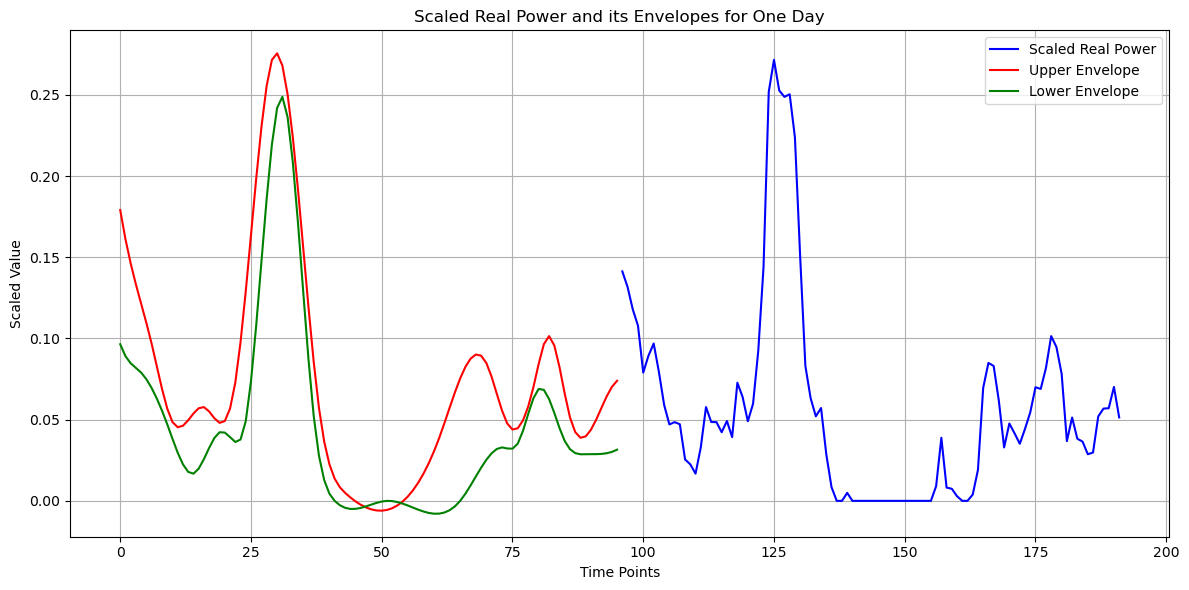

In [91]:
# 1. Load the data

# 1. Load the data
data = pd.read_csv("PreAndRealTogetherBeforeDay_Tim.csv")

# 2. Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_values = scaler.fit_transform(data[['std_predpower', 'std_realpower']])
data['scaled_predpower'] = scaled_values[:, 0]
data['scaled_realpower'] = scaled_values[:, 1]

# 3. Calculate the new envelopes
upper_envelope = get_envelope(data['scaled_realpower'].values, mode='maxima')
lower_envelope = get_envelope(data['scaled_realpower'].values, mode='minima')

# 4. Visualize one day's envelope

plt.figure(figsize=(12, 6))
plt.plot(data['scaled_realpower'][:n], label='Scaled Real Power', color='blue')
plt.plot(upper_envelope[:n], label='Upper Envelope', color='red')
plt.plot(lower_envelope[:n], label='Lower Envelope', color='green')
plt.title('Scaled Real Power and its Envelopes for One Day')
plt.xlabel('Time Points')
plt.ylabel('Scaled Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### 训练LSTM神经网络


对于第三步，以下是我设计的数据预处理策略：

1. `X`（输入）:
   - 对于每一天，`X` 包括当前天的预测值 `std_predpower` 以及实际值 `std_realpower` 和两个包络线 `upper_envelope` 和 `lower_envelope`。
   - 所以，每个样本在 `X` 中是一个形状为 `(96, 4)` 的数组，其中96是时间点的数量，4是上述三个特征的数量。

2. `y`（输出）:
   - 对于每一天，`y` 包括下一天的 `upper_envelope` 和 `lower_envelope` 的值。
   - 因此，每个样本在 `y` 中是一个形状为 `(96,2)` 的数组，其中 96 是两个包络线（每个包络线有96个点）的总时间点数。

具体来说，当我们使用当前天的数据（包括 `std_predpower`、`std_realpower`、`upper_envelope` 和 `lower_envelope`）作为输入时，我们希望模型能够预测接下来一天的 `upper_envelope` 和 `lower_envelope` 的值。

这种数据准备方式的目的是训练模型，使其能够根据当前天的信息预测接下来一天的包络线的变化。

当然可以，Adam 是一种自适应学习率优化算法，旨在结合 AdaGrad 和 RMSProp 的最佳特性。下面是 Adam 的一些关键特点和组成部分：

1. **动量 (Momentum)**: 
    - 简单的梯度下降会直接根据当前的梯度更新参数。然而，当我们在某个特定方向上看到了连续的相同梯度时，我们可能会希望加速更新，就像滚下山坡的球一样。
    - 动量的思想就是引入一个速度概念，它考虑了之前梯度的平均值。这有助于加速收敛并解决一些小的局部最优问题。
    
2. **RMSProp (Root Mean Square Propagation)**:
    - RMSProp 是一种调整学习率的方法。它根据之前的平方梯度的平均值来调整每个参数的学习率。
    - 这意味着对于经常更新的参数，学习率会降低，而对于不常更新的参数，学习率会增加。这使得算法在各个方向上都能更稳定地前进。当某个参数的梯度绝对值（平方）很大时，这意味着我们需要对该参数进行较大的更新，因为损失函数在该参数方向上变化很大。平方梯度的移动平均值捕捉了这种变化的大小。频繁的大更新：

如果一个参数经常有大的梯度（即该参数频繁地需要大的更新），其平方梯度的移动平均值会增大。

3. **偏差修正**:
    - 由于 Adam 使用了梯度的移动平均值和平方梯度的移动平均值，因此在训练的早期，这些估计可能会偏向于零。为了解决这个问题，Adam 引入了一个偏差修正机制，确保这些估计在训练的早期就是有意义的。

4. **自适应学习率**:
    - 正如您所提到的，Adam 会自动调整学习率，结合了上述两种策略（动量和 RMSProp）。

Adam 的更新规则如下：
1. 计算梯度的移动平均值（动量）。
2. 计算梯度平方的移动平均值。
3. 对上述两个移动平均值进行偏差修正。
4. 使用修正后的值来更新参数。

在实际应用中，Adam 通常表现得相当好，需要的调整较少，并且通常可以较快地收敛。这也是为什么它在深度学习领域如此受欢迎的原因之一。

希望这可以帮助您更深入地理解 Adam！如果您有任何其他问题，我会很高兴为您解答。

In [60]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.optimizers import Adam

# 1. Load the data
data = pd.read_csv("Envelope_PreAndRealTogetherBeforeDay_Tim.csv")

# 2. Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[['std_predpower', 'std_realpower', 'upper_envelope', 'lower_envelope']])

# 3. Split the dataset into training and testing sets
sequence_length = 96  # one day
X, y = [], []

for i in range(len(scaled_data) - sequence_length):
    X.append(scaled_data[i:i + sequence_length, :4])  # 行列索引std_predpower, std_realpower, upper_envelope,lower_envelope
    y.append(scaled_data[i + sequence_length:i + sequence_length +2, 2:4])  # upper_envelope and lower_envelope


X = np.asarray(X) # X 形如【【第一天的数据【std_predpower】【std_realpower】【upper_envelope】【lower_envelope】】，【第二天的数据】，【第三天的数据】】

y = np.asarray(y)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False) # 将数据集的后20%作为测试集
scaled_data

E:\CodeApp\Conda\envs\CETLAB\lib\site-packages\ipykernel_launcher.py:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
E:\CodeApp\Conda\envs\CETLAB\lib\site-packages\ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


array([[3.55038546e-01, 5.24758483e-03, 9.78623491e-01, 0.00000000e+00],
       [3.55038546e-01, 5.24758483e-03, 9.80576372e-01, 6.05230908e-04],
       [3.55093612e-01, 1.23381917e-02, 9.82099357e-01, 1.09283263e-03],
       ...,
       [           nan,            nan, 1.03447505e-01, 8.99177798e-01],
       [           nan,            nan, 5.26747725e-02, 9.48694211e-01],
       [           nan,            nan, 0.00000000e+00, 1.00000000e+00]])

In [32]:
# 4. Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 4)))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=True))  # Add return_sequences=True here
model.add(Dropout(0.2))

model.add(Dense(units=2))  # Change this to 2

model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')


# 5. Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), shuffle=False)

# 6. Use the trained model for prediction (for example, on the test set)
predictions = model.predict(X_test)

# 保存整个模型
model.save('my_model.h5')

# end
print("the end")

E:\CodeApp\Conda\envs\CETLAB\lib\site-packages\ipykernel_launcher.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
E:\CodeApp\Conda\envs\CETLAB\lib\site-packages\ipykernel_launcher.py:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


IndexError: tuple index out of range

这行代码中使用了 `model.fit()` 方法，这是 Keras 中用于训练模型的方法。下面是这个方法中参数的解释：

1. **X_train, y_train**:
   - `X_train` 和 `y_train` 是你的训练数据和对应的标签。模型会使用这些数据进行训练。
   
2. **epochs=100**:
   - 这指定了训练数据应该被遍历多少次。每次遍历整个数据集称为一个 epoch。100 个 epochs 意味着整个训练数据集会被遍历 100 次。
   
3. **batch_size=32**:
   - 在每次参数更新之前，网络应该看多少个样本。批量大小为 32 意味着在每次参数更新之前，网络会看 32 个样本。较小的批量可能会导致训练过程更加不稳定，但可能会收敛到更好的/不同的局部最小值；而较大的批量可能会使训练更加稳定，但需要更多的内存。
   
4. **validation_data=(X_test, y_test)**:
   - 在每个 epoch 结束时，模型会在这些验证数据上评估其性能。这不会影响模型的训练（即不会根据这些数据更新参数），但允许你监控模型在训练期间的性能。这有助于识别过拟合。
   
5. **shuffle=False**:
   - 是否在每个 epoch 开始时随机打乱输入样本的顺序。对于时间序列数据（如我们的案例），通常应该避免打乱样本，因为数据的顺序可能是有意义的。
   
返回值 `history` 是一个包含训练过程中的信息（如每个 epoch 的训练和验证损失）的对象。这可以用来后续分析模型的训练过程，例如绘制损失曲线。

在神经网络的上下文中，一个“样本”通常指的是输入到网络的单个数据点及其对应的目标值。对于我们的案例，一个样本就是一个具有给定历史长度的时间窗口内的数据，以及这个时间窗口后面的上下包络线值。

具体地说，对于我们的模型和数据预处理方式：

- 一个样本的输入部分（即在 `X_train` 或 `X_test` 中的一个项）是一个形状为 `(sequence_length, 4)` 的数组，其中 `sequence_length` 是我们选择的时间窗口长度（在这种情况下是96，代表一天的数据），4 代表我们的四个特征：预测值、实际值和两个包络线。
- 一个样本的目标部分（即在 `y_train` 或 `y_test` 中的一个项）是一个形状为 `(96, 2)` 的数组，代表未来一天的上下包络线值。

当我们说“批量大小为32”时，我们的意思是模型在每次前向和反向传播过程中都会处理32个这样的样本，然后根据这32个样本的平均损失更新其权重。

这32个样本是从训练数据集（`X_train` 和 `y_train`）中连续抽取的。例如，训练过程的第一个批次会处理 `X_train` 的前32个时间窗口及其对应的目标值，第二个批次会处理接下来的32个时间窗口，依此类推。

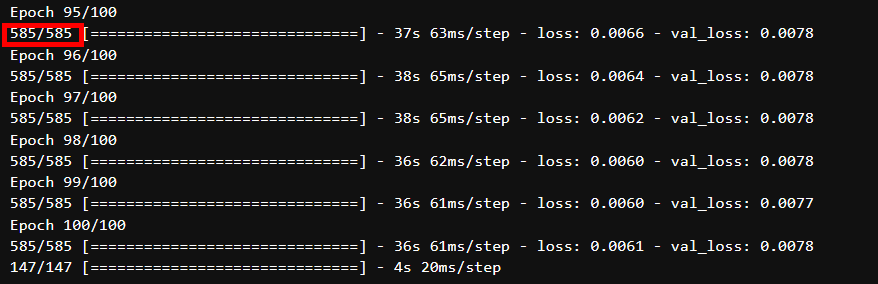
数字 $585 / 585$ 表示当前的迭代次数 (batch iteration) 与整个训练数据集中的总迭代次数。 具体来说，这个数字代表了模型在当前训练周期 (epoch) 内完成了多少批次的训练。
为了明确这个概念，我们可以进行一些简单的计算:
假设我们的训练数据集有 $N$ 个样本，批次大小 (batch size) 为 $B$ 。那么，每一个训练周期 (epoch) 需要的迭代次数（即完整地遍历一次训练数据集所需的批次数）是:
$$
\text { iterations per epoch }=\left\lceil\frac{N}{B}\right\rceil
$$
其中，$\lceil{x}\rceil$ 表示不小于 $x$ 的最小整数（向上取整）。
在你的案例中，每个训练周期中的迭代次数是 585 ，这意味着:
$$
\left\lceil\frac{N}{32}\right\rceil=585
$$
从中我们可以推测，你的训练数据集大约有 $585 \times 32=18720$ 个样本（23565*0.8=18852）。
因此，数字 $585 / 585$ 表示在当前训练周期（epoch）中，模型已经完成了 585 个批次的训 练，即已经完整地遍历了一次训练数据集。

In [103]:
# 保存整个模型
model.save('my_model.h5')

# load 模型。
# 加载先前保存的模型。当你保存和加载模型时，确保你使用的Keras版本是一致的，因为不同版本之间可能存在不兼容的情况。version = 2.10.0
# loaded_model = load_model('my_model.h5')

### 模型的分析与评价

分析和可视化一个模型的效果是模型评估的关键部分。以下是一些建议的步骤：

1. **损失曲线**: 
    * 绘制训练和验证损失随着迭代次数（epoch）的变化情况。
    * 这可以帮助你识别模型是否过拟合。当训练损失持续下降但验证损失开始上升时，通常表示模型过拟合。

In [61]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

NameError: name 'history' is not defined

In [33]:
X_test.shape,X_train.shape,X.shape,len(scaled_data)
# 0.2 的分割使得预测无法进行


((4695,), (18777,), (23472,), 23566)

In [23]:
X_test[1]

array([[0.16847467, 0.07406936, 0.98543253, 0.00225924],
       [0.16852974, 0.11600944, 0.98563563, 0.00226968],
       [0.16855727, 0.27520238, 0.98583523, 0.00231286],
       [0.16861233, 0.35675534, 0.98600899, 0.00237993],
       [0.16646476, 0.41370592, 0.98613458, 0.00246202],
       [0.16214207, 0.54008572, 0.98618968, 0.00255029],
       [0.15779185, 0.52895052, 0.98616199, 0.00263587],
       [0.15346916, 0.51898145, 0.98607942, 0.00270993],
       [0.14909141, 0.422079  , 0.98597988, 0.00276359],
       [0.14465859, 0.41926728, 0.98590131, 0.00278802],
       [0.14022577, 0.45408028, 0.98588164, 0.00278117],
       [0.13579295, 0.43770409, 0.9859469 , 0.00276828],
       [0.13320485, 0.41495599, 0.98607544, 0.00278141],
       [0.13240639, 0.42413286, 0.98623371, 0.0028424 ],
       [0.13160793, 0.56772661, 0.98638817, 0.00293217],
       [0.13080947, 0.62820225, 0.98650528, 0.00302142],
       [0.13078194, 0.61042547, 0.98656823, 0.00308084],
       [0.1315804 , 0.66227803,

2. **预测与实际结果对比**:
    * 使用模型进行预测并与实际值进行比较。
    * 对于时间序列数据，你可以绘制预测值和实际值随时间变化的曲线。

146/146 [==============================] - 3s 18ms/step


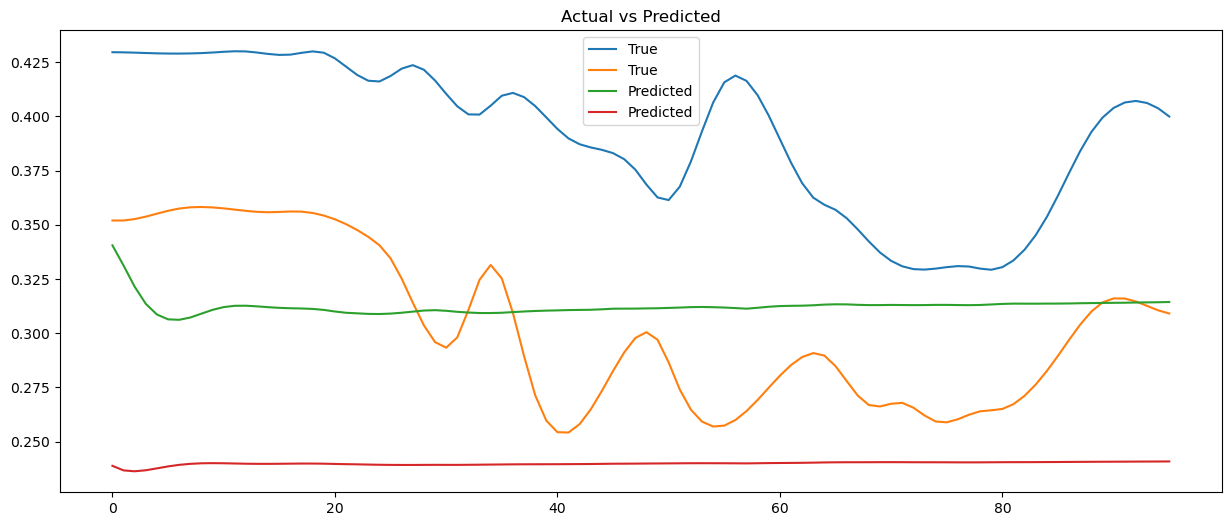

In [106]:
n = 100

predictions = model.predict(X_test)
plt.figure(figsize=(15, 6))
plt.plot(y_test[n], label='True')
plt.plot(predictions[n], label='Predicted')
plt.legend()
plt.title('Actual vs Predicted')
plt.show()


In [55]:
y_test.shape


(18698, 96, 4)

3. **计算性能指标**:
    * 根据任务的性质，你可能需要计算某些性能指标，如均方误差 (MSE)、均方根误差 (RMSE)、平均绝对误差 (MAE) 等。
    * 这些指标可以提供模型预测质量的定量评估。

In [26]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
mse = mean_squared_error(y_test[n], predictions[n])
mae = mean_absolute_error(y_test[n], predictions[n])
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")

Mean Squared Error: 3.95919143275713e-05
Mean Absolute Error: 0.0023401260817326325


4. **残差分析**:
    * 残差是观察值与模型预测值之间的差异。
    * 你可以绘制残差直方图来查看其分布，或者绘制残差随时间变化的曲线来检查任何模式。理想情况下，残差应该是随机的，并且没有可识别的模式。

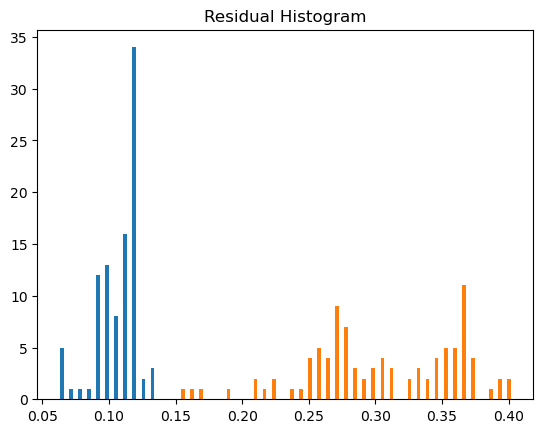

In [60]:
residuals = y_test[n] - predictions[n]
plt.hist(residuals, bins=50)
plt.title('Residual Histogram')
plt.show()

5. **查看模型结构**:
    * 可视化模型的结构和各层的参数数量。

In [56]:
from keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [65]:
predictions = []

# 循环遍历测试集
for sample in X_test
    # 将样本扩展到适当的形状以适应模型
    sample = np.expand_dims(sample, axis=0)
    
    # 使用模型进行预测
    predicted_values = model.predict(sample)
    
    # 将预测值添加到结果列表中
    predictions.append(predicted_values)

# 将预测值转换为numpy数组
predictions = np.array(predictions).squeeze()

# 接下来，您可以继续比较这些预测值与y_test中的真实值


SyntaxError: invalid syntax (1158257422.py, line 4)

In [74]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.optimizers import Adam

# 1. Load the data
data = pd.read_csv("Envelope_PreAndRealTogetherBeforeDay_Tim.csv")

# 2. Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[['std_predpower', 'std_realpower', 'upper_envelope', 'lower_envelope']])

# 3. Split the dataset into training and testing sets
sequence_length = 96  # one day
X, y = [], []

for i in range(len(scaled_data) - sequence_length * 2):
    X.append(scaled_data[i:i + sequence_length, :4])  # 行列索引，std_predpower, std_realpower, upper_envelope,lower_envelope
    y.append(scaled_data[i + sequence_length:i + sequence_length * 2, 2:4])  # upper_envelope and lower_envelope

X = np.array(X)
y = np.array(y)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

X_train.shape, X_test.shape, y_train.shape, y_test.shape , X.shape , len(scaled_data)

((18662, 96, 4),
 (4666, 96, 4),
 (18662, 96, 2),
 (4666, 96, 2),
 (23328, 96, 4),
 23520)

In [75]:
# 4. Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 4)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))  # Add return_sequences=True here
model.add(Dropout(0.2))
model.add(Dense(units=2))  # Change this to 2

model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')


# 5. Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), shuffle=False)

# 6. Use the trained model for prediction (for example, on the test set)
predictions = model.predict(X_test)

In [98]:
# 保存整个模型
model.save('modelv1.h5')

# load 模型。
# 加载先前保存的模型。当你保存和加载模型时，确保你使用的Keras版本是一致的，因为不同版本之间可能存在不兼容的情况。version = 2.10.0
# loaded_model = load_model('my_model.h5')

In [109]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[['std_predpower', 'std_realpower', 'upper_envelope', 'lower_envelope']])

def predict_next_day(model, data, date_str):
    # 获取给定日期的数据
    current_day_data = data[data['full_time'].str.startswith(date_str)]
    
    # 确保有96个数据点
    if len(current_day_data) != 96:
        raise ValueError(f"Data for {date_str} doesn't have 96 points.")
    
    # 提取并标准化所需的列
    current_day_values = current_day_data[['std_predpower', 'std_realpower', 'upper_envelope', 'lower_envelope']].values
    current_day_scaled = scaler.transform(current_day_values)
    
    # 调整数据形状以适应模型
    input_data = np.expand_dims(current_day_scaled, axis=0)
    
    # 预测
    predicted_values = model.predict(input_data)
    
    # 如果需要，您可以反标准化预测值
    # predicted_unscaled = scaler.inverse_transform(predicted_values[0])
    
    return predicted_values[0]

# 使用上述函数进行预测
predicted_next_day = predict_next_day(model, data, '2023-1-20')
print(predicted_next_day)



1/1 [==============================] - 0s 29ms/step
[[0.3395387  0.23864822]
 [0.328956   0.23634379]
 [0.31815884 0.2357727 ]
 [0.30973884 0.2361391 ]
 [0.30534095 0.23706484]
 [0.30368483 0.2379861 ]
 [0.3039146  0.23870061]
 [0.30470568 0.23906994]
 [0.30535877 0.23913206]
 [0.3059086  0.23903663]
 [0.3063529  0.23887958]
 [0.3065732  0.23870175]
 [0.3065522  0.23853445]
 [0.3064902  0.23842138]
 [0.30666777 0.23840049]
 [0.30696693 0.23843545]
 [0.30704057 0.23846157]
 [0.3069842  0.23849458]
 [0.30664247 0.23849604]
 [0.30635294 0.23851229]
 [0.3063586  0.23856461]
 [0.30620605 0.23856516]
 [0.3061733  0.23857123]
 [0.30620384 0.23857142]
 [0.30626306 0.23856422]
 [0.3063813  0.23856002]
 [0.3065337  0.23855883]
 [0.3066097  0.23854746]
 [0.30662072 0.23853384]
 [0.30653924 0.23851387]
 [0.30655602 0.23851757]
 [0.3064469  0.23849955]
 [0.3061881  0.23845693]
 [0.3059446  0.2384144 ]
 [0.30573446 0.23836687]
 [0.30552968 0.23830593]
 [0.30536285 0.23823765]
 [0.30525059 0.23816659

E:\CodeApp\Conda\envs\CETLAB\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"


通过上述方法，你可以对模型的性能有一个全面的了解，并在必要时进行进一步的调整和优化。

E:\CodeApp\Conda\envs\CETLAB\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"


1/1 [==============================] - 0s 22ms/step


E:\CodeApp\Conda\envs\CETLAB\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"


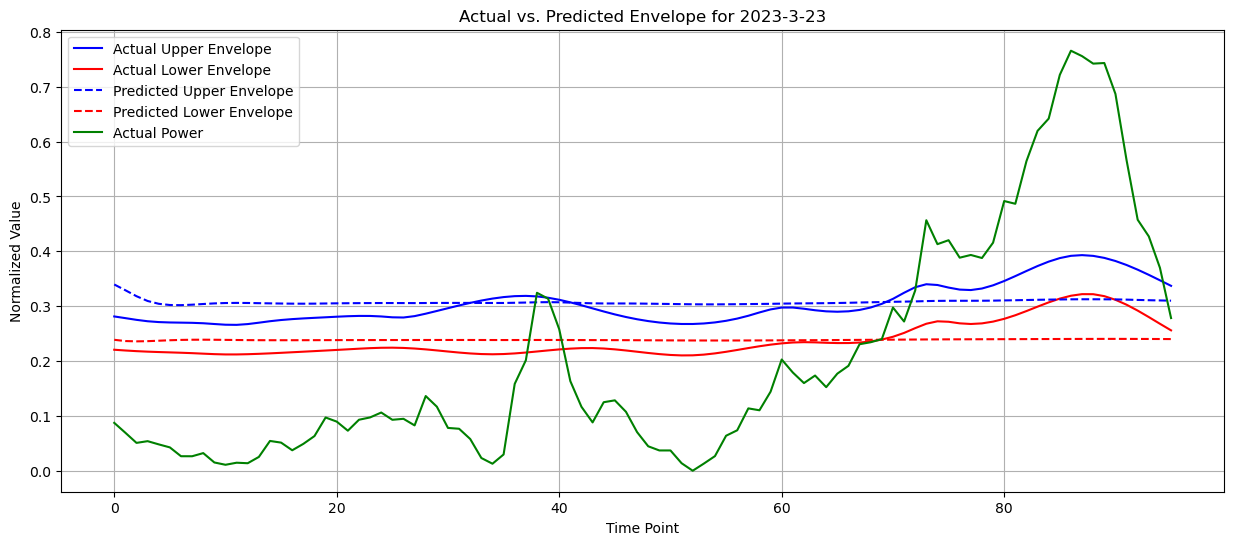

In [84]:

# 1. Reload the CSV data
data = pd.read_csv("Envelope_PreAndRealTogetherBeforeDay_Tim.csv")

# 2. Normalize the data again
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[['std_predpower', 'std_realpower', 'upper_envelope', 'lower_envelope']])

# Use the provided function to predict the next day
predicted_next_day = predict_next_day(model, data, '2023-2-20')

# Visualize the actual and predicted envelope for '2023-3-23'
current_day_data = data[data['full_time'].str.startswith('2023-2-20')]
current_day_scaled = scaler.transform(current_day_data[['std_predpower', 'std_realpower', 'upper_envelope', 'lower_envelope']].values)

plt.figure(figsize=(15, 6))

# Actual upper and lower envelopes
plt.plot(current_day_scaled[:, 2], label="Actual Upper Envelope", color="blue")
plt.plot(current_day_scaled[:, 3], label="Actual Lower Envelope", color="red")

# Predicted upper and lower envelopes
plt.plot(predicted_next_day[:, 0], label="Predicted Upper Envelope", linestyle='dashed', color="blue")
plt.plot(predicted_next_day[:, 1], label="Predicted Lower Envelope", linestyle='dashed', color="red")

# Visualize the actual power for '2023-3-23'
plt.plot(current_day_scaled[:, 1], label="Actual Power", color="green")

plt.title("Actual vs. Predicted Envelope for 2023-3-23")
plt.xlabel("Time Point")
plt.ylabel("Normalized Value")
plt.legend()
plt.grid(True)
plt.show()
